## 0. Setup Paths and Other Stuff

In [2]:
import os

import cv2
import numpy as np
import tensorflow as tf

from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

from PIL import Image
from PIL import ImageFilter

from IPython.display import display

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobilenet'
WORKSPACE_PATH = os.path.join('Tensorflow', 'workspace')

paths = {
    'IMAGE_PATH': os.path.join(WORKSPACE_PATH,'images'),
    'SAVED_MODEL_PATH': os.path.join(WORKSPACE_PATH,'models', CUSTOM_MODEL_NAME, 'export', 'saved_model')
}

files = {
    'LABELMAP': os.path.join(WORKSPACE_PATH,'annotations', 'label_map.pbtxt'),
}

## 1. Load Saved Model

In [ ]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [4]:
# Load the SavedModel
model = tf.saved_model.load(paths['SAVED_MODEL_PATH'])

## 2. Detect from an Image

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

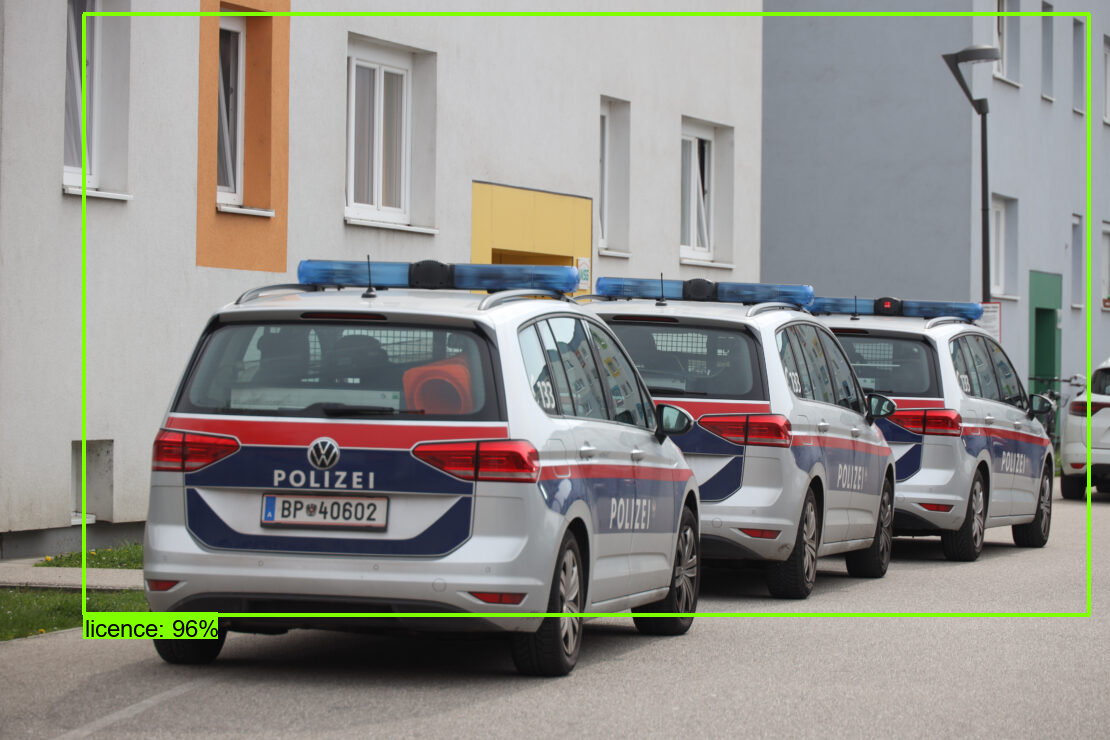

In [8]:
# Preprocess input 
# IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'Autos', '20230913_210950.jpg')
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'sonder_3.jpg')
# IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'bgld_1.jpg')


image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_np = np.array(image)

# Perform inference
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0).astype(np.uint8))
detections = model(input_tensor)

# Remove extra dim from array
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections   

# Extract information from the detections
boxes = detections['detection_boxes']
classes = detections['detection_classes'].astype(int)
scores = detections['detection_scores']

# Visualize the results
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            boxes,
            classes,
            scores,
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=2,
            min_score_thresh=.5,
            agnostic_mode=False)

# Convert to PIL image
h, w, _ = image_np_with_detections.shape
image_pil = Image.fromarray(image_np_with_detections)

display(image_pil)
# resized_image = image_pil.resize((int(w/8), int(h/8)))
# display(resized_image)


# Save inference
SAVE_PATH = os.path.join(paths['IMAGE_PATH'], 'Autos', 'aaaaaaaaaa.jpg')
image_pil.save(SAVE_PATH)

## 3. Real Time Detections from your Webcam or Video File

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[161.26038551 113.68140221 247.79291153 298.7972641 ]


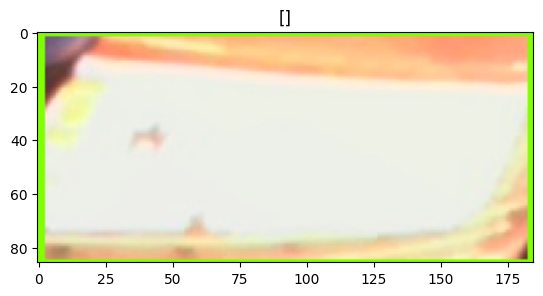

Exit program.


In [28]:
region_threshold = 0.1
detection_threshold = 0.6

# VIDEO_PATH = os.path.join(paths['IMAGE_PATH'], 'Autos', '20231106_222316.mp4')
# cap = cv2.VideoCapture(VIDEO_PATH)

cap = cv2.VideoCapture(0)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        print("End of video.")
        break

    # Preprocess input 
    image_np = np.array(frame)
    
    # Perform inference
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0).astype(np.uint8))
    detections = model(input_tensor)

    # Remove extra dim from array
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections   
    
    # Extract information from the detections
    scores = detections['detection_scores']
    boxes = detections['detection_boxes']
    classes = detections['detection_classes'].astype(int)

    # Visualize the results
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                boxes,
                classes,
                scores,
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=detection_threshold,
                agnostic_mode=False)
    
    try: 
        text, region = ocr(image_np_with_detections, detections, detection_threshold, region_threshold)
    except:
        pass

    h, w, _ = image_np_with_detections.shape
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (w, h)))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        print("Exit program.")
        break
    
cap.release()
cv2.destroyAllWindows()

## 4. Apply OCR to Detections

In [ ]:
import easyocr 
from matplotlib import pyplot as plt

In [ ]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [26]:
def ocr(image, detections, detection_threshold, region_threshold):
    scores = list(filter(lambda score: score > detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for index, box in enumerate(boxes):    
        roi = box*[height, width, height, width]
        print(roi)
        
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        
        reader = easyocr.Reader(['de'])
        ocr_result = reader.readtext(region)
        # print(ocr_result)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        # plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.imshow(region)
        plt.title(text)
        plt.show()
        
        return text, region

In [27]:
region_threshold = 0.1
DETECTION_THRESHOLD = 0.6
ocr(image_np_with_detections, detections, DETECTION_THRESHOLD, region_threshold)